# Installing Libraries If Needed

In [1]:
# Install dependencies if needed
# !pip uninstall -y box2d-py
!pip install swig
!pip install gymnasium[box2d] imageio imageio[ffmpeg]


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp311-cp311-linux_x86_64.whl size=2379451 sha256=f0c31fa3b247f61d051d7400b9d74743b0b387830f533f320eaa731492f417ed
  Stored in directory: /root/.cache/pip/wheels/ab/f1/0c/d56f4a2bdd12bae0a0693ec33f2f0daadb5eb9753c78fa5308
Successfully built box2d-py


# Importing Libraries

In [2]:
import gymnasium as gym
import numpy as np
import random
import imageio  # For GIF generation
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from collections import deque, namedtuple
from itertools import count
from IPython.display import display, clear_output, HTML
import IPython
import pandas as pd
import os
from datetime import datetime
from tqdm.notebook import tqdm
from IPython.display import clear_output

# Global Parameters

In [3]:
LUNARLANDER_PARAMS = {
    "render_mode": "rgb_array",
    # "enable_wind": True,
    # "wind_power": 15.0,
    # "gravity": -10.0
}

env = gym.make("LunarLander-v3", **LUNARLANDER_PARAMS)

STATE_SIZE = env.observation_space.shape[0]
ACTION_SIZE = env.action_space.n
print(f"State size: {STATE_SIZE}, Action size: {ACTION_SIZE}")

HYPERPARAMS = {
    "BATCH_SIZE": 128,
    "GAMMA": 0.99,
    "EPS_START": 1.0,
    "EPS_END": 0.05,
    "EPS_DECAY": 1000,
    "TAU": 0.005,
    "LR": 1e-4,
    "REPLAY_MEMORY_SIZE": 10000,
    "HIDDEN_LAYER_SIZE": 128,
    "NUM_EPISODES": 500,
    "TARGET_UPDATE_INTERVAL": 10,
    "MAX_STEPS_PER_EPISODE": 500,
    "GIF_FPS": 30,
}

State size: 8, Action size: 4


# Neural Network

In [4]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


# Replay Memory (Experience Replay)

In [5]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward", "done"))

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Action Selection

In [6]:
# Action Selection with Epsilon-Greedy Strategy
def select_action(state, policy_net, steps_done, params):
    eps_threshold = params["EPS_END"] + (params["EPS_START"] - params["EPS_END"]) * \
        np.exp(-1.0 * steps_done / params["EPS_DECAY"])

    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).argmax().view(1, 1)
    else:
        return torch.tensor([[random.randrange(ACTION_SIZE)]], dtype=torch.long)

# Training Loop

In [7]:
from datetime import datetime

def train_dqn(params):
    params = params.copy()  # Ensure params are not modified globally

    # Create a fresh environment every time
    env = gym.make("LunarLander-v3", **LUNARLANDER_PARAMS)

    # Set device (CPU or GPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    policy_net = DQN(STATE_SIZE, ACTION_SIZE, params["HIDDEN_LAYER_SIZE"]).to(device)
    target_net = DQN(STATE_SIZE, ACTION_SIZE, params["HIDDEN_LAYER_SIZE"]).to(device)
    target_net.load_state_dict(policy_net.state_dict())

    optimizer = optim.Adam(policy_net.parameters(), lr=params["LR"])
    memory = ReplayMemory(params["REPLAY_MEMORY_SIZE"])

    episode_rewards = []
    steps_done = 0

    for i_episode in range(params["NUM_EPISODES"]):
        state, _ = env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        total_reward = 0

        for t in count():
            action = select_action(state, policy_net, steps_done, params).to(device)
            steps_done += 1
            observation, reward, terminated, truncated, _ = env.step(action.item())
            total_reward += reward

            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) if not terminated else None

            memory.push(
                state,
                action,
                next_state,
                torch.tensor([reward], dtype=torch.float32, device=device),
                torch.tensor([terminated], dtype=torch.bool, device=device)
            )

            state = next_state

            if len(memory) > params["BATCH_SIZE"]:
                transitions = memory.sample(params["BATCH_SIZE"])
                batch = Transition(*zip(*transitions))

                non_final_mask = torch.tensor(
                    tuple(map(lambda s: s is not None, batch.next_state)),
                    dtype=torch.bool,
                    device=device
                )

                non_final_next_states = torch.cat([s.to(device) for s in batch.next_state if s is not None])
                state_batch = torch.cat([s.to(device) for s in batch.state])
                action_batch = torch.cat([a.to(device) for a in batch.action])
                reward_batch = torch.cat([r.to(device) for r in batch.reward])

                state_action_values = policy_net(state_batch).gather(1, action_batch)
                next_state_values = torch.zeros(params["BATCH_SIZE"], device=device)
                with torch.no_grad():
                    next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

                expected_state_action_values = (next_state_values * params["GAMMA"]) + reward_batch
                loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if terminated or truncated:
                episode_rewards.append(total_reward)
                break

        if i_episode % params["TARGET_UPDATE_INTERVAL"] == 0:
            target_net.load_state_dict(policy_net.state_dict())

        clear_output(wait=True)
        plt.plot(episode_rewards)
        plt.xlabel("Episode")
        plt.ylabel("Total Reward")
        plt.title("Training Progress")
        plt.show()

    print("Training Complete")
    env.close()

    summary = {
        "date": datetime.now().strftime("%Y-%m-%d %H:%M"),
        "lr": params["LR"],
        "batch_size": params["BATCH_SIZE"],
        "eps_decay": params["EPS_DECAY"],
        "episodes": params["NUM_EPISODES"],
        "average_reward": np.mean(episode_rewards),
        "max_reward": np.max(episode_rewards),
        "min_reward": np.min(episode_rewards),
    }

    return policy_net, summary, episode_rewards


# Gif Generation

In [8]:
def generate_gif(policy_net, filename="lunar_lander_v3.gif", frame_skip=2):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    frames = []
    state, _ = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

    for t in range(HYPERPARAMS["MAX_STEPS_PER_EPISODE"]):
        if t % frame_skip == 0:  # Skip frames to reduce GIF size
            frame = env.render()
            frames.append(frame)

        with torch.no_grad():
            action = policy_net(state).argmax(dim=1).view(1, 1).cpu().numpy()

        state, _, terminated, truncated, _ = env.step(action.item())
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)

        if terminated or truncated:
            break

    if len(frames) == 0:
        print("No frames captured! Ensure the environment is rendering correctly.")
        return

    output_dir = './content'
    os.makedirs(output_dir, exist_ok=True)
    save_path = os.path.join(output_dir, filename)

    imageio.mimsave(save_path, frames, fps=HYPERPARAMS["GIF_FPS"])

    with open(save_path, "rb") as file:
        display(IPython.display.Image(data=file.read(), format="gif"))

    print(f"GIF saved at: {save_path}")

# Results Table

In [9]:
results_table = []
def output_results_table(results_table):
    df = pd.DataFrame(results_table)
    # print(df)
    return df

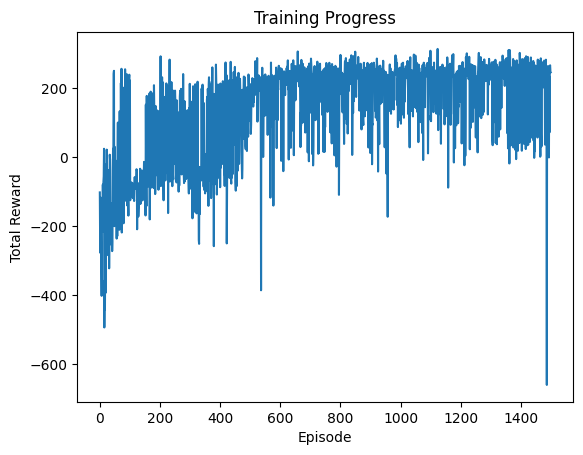

Training Complete


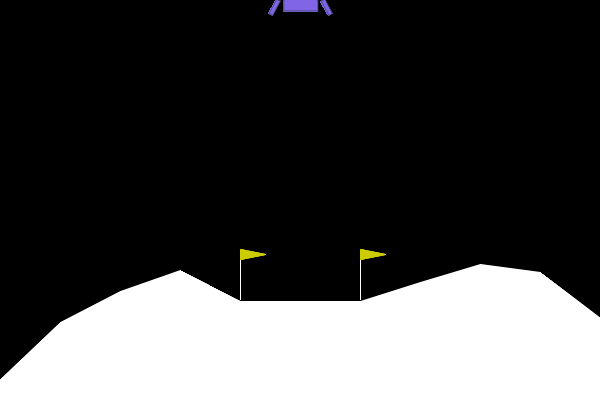

GIF saved at: ./content/lunar_lander_v3.gif


,date,lr,batch_size,eps_decay,episodes,average_reward,max_reward,min_reward
0,2025-04-01 03:02,0.0001,128,1800,1500,137.652241,313.71089,-661.220856


In [12]:
HYPERPARAMS["EPS_DECAY"] = 1800
HYPERPARAMS["NUM_EPISODES"] = 1500
policy_net, summary, rewards = train_dqn(HYPERPARAMS)
results_table.append(summary)

generate_gif(policy_net)
output_results_table(results_table)